# Movie data analysis between genre and profit ratio

The movie business might look pretty glamorous and lucrative.
I wanted to take a look at how the major genres perform around the world relative to their global average performance to determine which genres are the most profitable.I also think that genre is so important for any studio creating a new movie . If we investigate this data, we can to an extent understand what genre is the best for audience. I wanted to use this dataset to get a deeper understanding of profit ratio between difference genre. I will be performing ANOVA and t-test  between the genres and profit ratio.

## Part 1: Preparing data

In [1]:
#import library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import seaborn as sns
import zipfile
import statsmodels.api as sm
from statsmodels.formula.api import ols
sns.set()

In [12]:
#read data
movie_budgets =pd.read_csv('C:/Users/thivnguyen/Git/Flatiron/CapStoneProject/zippedData/tn.movie_budgets.csv.gz')
zip_file = "C:/Users/thivnguyen/Git/Flatiron/CapStoneProject/zippedData/im.db.zip"

try:
    with zipfile.ZipFile(zip_file, 'r') as z:
        z.extractall("zippedData/unZippedim.db")
        print("Extracted all")
except:
    print("Invalid file")
conn = sqlite3.connect("zippedData/unZippedim.db/im.db")
##change trelease_date object type to datetime type
movie_budgets["release_date"] = pd.to_datetime(movie_budgets["release_date"])
#movie_budgets.info()\
#clean movie_budget dataset
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

movie_budgets['production_budget'] = movie_budgets['production_budget'].apply(clean_currency).astype('float64')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].apply(clean_currency).astype('float64')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].apply(clean_currency).astype('float64')


Extracted all


In [13]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   float64       
 4   domestic_gross     5782 non-null   float64       
 5   worldwide_gross    5782 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 271.2+ KB


In [44]:
q1= """
SELECT * 
FROM movie_basics
INNER JOIN movie_ratings
USING("movie_id")
INNER JOIN movie_akas
USING("movie_id")
"""
sql_dataset_merge1 = pd.read_sql(q1,conn)
#find duplicate rows across 'title', 'start_year','runtime_minutes' columns 
duplicateRows = sql_dataset_merge1[sql_dataset_merge1.duplicated(['movie_id','title', 'start_year','runtime_minutes'])]
data1= sql_dataset_merge1.drop(duplicateRows.index,axis=0)
#create new "release_year" column for merging 2 datatset
movie_budgets['release_year']= movie_budgets['release_date'].dt.year
##merge 2 dataset by using title and released year
merge_data= movie_budgets.merge(data1, how= 'inner', left_on=['movie','release_year'], right_on= ['title','start_year'])
dataset= merge_data[[ 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross',
       'start_year',
       'runtime_minutes', 'genres']]
#drop 7 rows with NA
dataset=dataset.dropna()
## calulate profit by subtracting gross and budget and foreign gross by subtracting gross and budget domestic_gross
dataset['profit']= dataset['worldwide_gross']- dataset['production_budget']
dataset['foreign_gross']= dataset['worldwide_gross']- dataset['domestic_gross']
#dataset.loc[dataset['profit'] < 0, 'profit']= 0
##calulate profit ratio
dataset['profit_ratio'] = (dataset['profit'] -dataset['production_budget'] )/ dataset['production_budget']
## top 5 greatest profit ratio 
dataset.sort_values(['profit_ratio'], ascending=False).head()


,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year,runtime_minutes,genres,profit,foreign_gross,profit_ratio
1565,2015-07-10,The Gallows,100000.0,22764410.0,41656474.0,2015,81.0,"Horror,Mystery,Thriller",41556474.0,18892064.0,414.564740
1465,2012-01-06,The Devil Inside,1000000.0,53262945.0,101759490.0,2012,83.0,Horror,100759490.0,48496545.0,99.759490
1338,2010-10-20,Paranormal Activity 2,3000000.0,84752907.0,177512032.0,2010,91.0,Horror,174512032.0,92759125.0,57.170677
1242,2017-02-24,Get Out,5000000.0,176040665.0,255367951.0,2017,104.0,"Horror,Mystery,Thriller",250367951.0,79327286.0,49.073590
1436,2016-10-21,Moonlight,1500000.0,27854931.0,65245512.0,2016,111.0,Drama,63745512.0,37390581.0,41.497008


In [47]:
dataset

,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year,runtime_minutes,genres,profit,foreign_gross,profit_ratio
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,136.0,"Action,Adventure,Fantasy",6.350639e+08,8.046000e+08,0.546673
1,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019,113.0,"Action,Adventure,Sci-Fi",-2.002376e+08,1.070000e+08,-1.572108
2,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,141.0,"Action,Adventure,Sci-Fi",1.072414e+09,9.440081e+08,2.243841
3,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2018,149.0,"Action,Adventure,Sci-Fi",1.748134e+09,1.369319e+09,4.827114
4,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,2017,120.0,"Action,Adventure,Fantasy",3.559452e+08,4.269209e+08,0.186484
...,...,...,...,...,...,...,...,...,...,...,...
1583,2017-01-27,Emily,27000.0,3547.0,3.547000e+03,2017,83.0,Drama,-2.345300e+04,0.000000e+00,-1.868630
1584,2015-09-01,Exeter,25000.0,0.0,4.897920e+05,2015,91.0,"Horror,Mystery,Thriller",4.647920e+05,4.897920e+05,17.591680
1585,2015-12-01,Dutch Kills,25000.0,0.0,0.000000e+00,2015,90.0,"Crime,Drama,Thriller",-2.500000e+04,0.000000e+00,-2.000000
1586,2011-11-25,The Ridges,17300.0,0.0,0.000000e+00,2011,89.0,"Drama,Horror,Thriller",-1.730000e+04,0.000000e+00,-2.000000


In [46]:
dataset.loc[dataset['profit_ratio'] < 0, 'profit_ratio']

1      -1.572108
7      -0.570359
8      -1.054538
9      -0.971716
21     -0.575101
          ...   
1582   -2.000000
1583   -1.868630
1585   -2.000000
1586   -2.000000
1587   -2.000000
Name: profit_ratio, Length: 762, dtype: float64

In [36]:

#find duplicate rows across 'title', 'start_year','runtime_minutes' columns 
duplicateRows = sql_dataset_merge1[sql_dataset_merge1.duplicated(['movie_id','title', 'start_year','runtime_minutes'])]
data1= sql_dataset_merge1.drop(duplicateRows.index,axis=0)

In [41]:
#create new "release_year" column for merging 2 datatset
movie_budgets['release_year']= movie_budgets['release_date'].dt.year
##merge 2 dataset by using title and released year
merge_data= movie_budgets.merge(data1, how= 'inner', left_on=['movie','release_year'], right_on= ['title','start_year'])
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1588 entries, 0 to 1587
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1588 non-null   int64         
 1   release_date       1588 non-null   datetime64[ns]
 2   movie              1588 non-null   object        
 3   production_budget  1588 non-null   float64       
 4   domestic_gross     1588 non-null   float64       
 5   worldwide_gross    1588 non-null   float64       
 6   release_year       1588 non-null   int64         
 7   movie_id           1588 non-null   object        
 8   primary_title      1588 non-null   object        
 9   original_title     1588 non-null   object        
 10  start_year         1588 non-null   int64         
 11  runtime_minutes    1581 non-null   float64       
 12  genres             1586 non-null   object        
 13  averagerating      1588 non-null   float64       
 14  numvotes

I want to split up the genres column cells so we can tally each genre individually. Next I'll remove the 'genres' column (with multiple values) and replace it with a 'genre' column (with single values). Then I'll make sure that there is a new row for each genre, so there will be multiple rows with the same movie_title.



In [48]:
df_split_genre = dataset.copy()
split_genre = df_split_genre['genres'].str.split(',').apply(pd.Series, 1).stack().reset_index(level=1, drop=True)
split_genre.name = 'genre_split'
df_split_genre = df_split_genre.drop(['genres'], axis=1).join(split_genre)
## filter released movie year from 2010 to 2020
df_split_genre= df_split_genre[df_split_genre['release_date'].dt.year >2010]
##differrence genre in the dataset
df_split_genre['genre_split'].unique()

array(['Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Thriller', 'Western',
       'Family', 'Crime', 'Comedy', 'Animation', 'Horror', 'Drama',
       'Romance', 'Mystery', 'Musical', 'History', 'Documentary',
       'Biography', 'Music', 'War', 'Sport', 'News'], dtype=object)

## Visualize dataset

In [56]:
##check outlier with genre New
df_split_genre[df_split_genre['genre_split']=="News"]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,start_year,runtime_minutes,profit,foreign_gross,profit_ratio,genre_split
1248,2015-09-11,The Visit,5000000.0,65206105.0,98677816.0,2015,43.0,93677816.0,33471711.0,17.735563,News


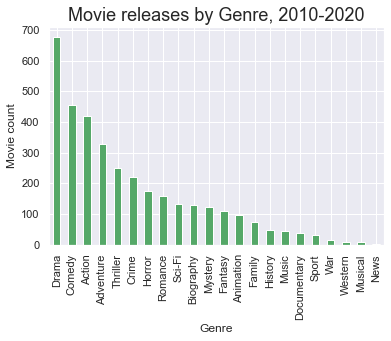

In [49]:
df_split_genre['genre_split'].value_counts().plot(kind='bar', color='g');
plt.title('Movie releases by Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

In terms of the number of releases worldwide, dramas and comedies top the list ( in North America) between 2010 and 2020 as more than 500 comedy films were released and over 800 drama films have been released.

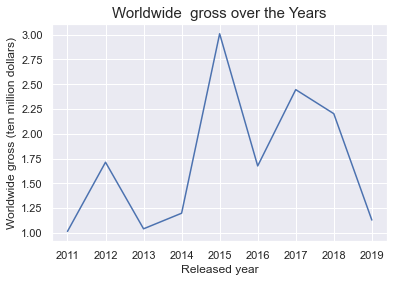

In [51]:

df_split_genre['start_year']= df_split_genre['release_date'].dt.year
gross_mean= df_split_genre.groupby(dataset['start_year'])['profit_ratio'].mean()
#print(gross_mean)
plt.plot(gross_mean)
plt.title('Worldwide  gross over the Years', size=15);
plt.xlabel('Released year', size=12)
plt.ylabel('Worldwide gross (ten million dollars)', size=12);

In [52]:
profit_ratio_genre=df_split_genre.groupby('genre_split')['profit_ratio'].mean().sort_values()
#profit_ratio_genre
genre_profit=df_split_genre[['genre_split','profit_ratio']].sort_values('genre_split').reset_index(level=0, drop=True)
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different genre
# ax = sns.boxplot(x='genre_split', y='profit_ratio', data=genre_profit)
# plt.xticks(rotation=45)

# plt.show()

## Hypothesis testing

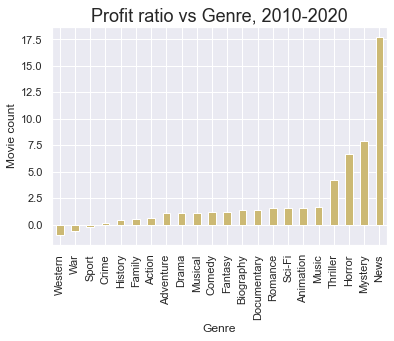

In [53]:
profit_ratio_genre=df_split_genre.groupby('genre_split')['profit_ratio'].mean().sort_values()
profit_ratio_genre.plot(kind='bar', color='y');
plt.title('Profit ratio vs Genre, 2010-2020', size=18)
plt.xlabel('Genre', size=12)
plt.ylabel('Movie count', size=12);

In [54]:


# Ordinary Least Squares (OLS) model
model = ols('profit_ratio ~ C(genre_split)', data=genre_profit).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# display model summary
#print(model.summary())

,sum_sq,df,F,PR(>F)
C(genre_split),12788.665577,21.0,3.640717,3.954486e-08
Residual,588289.955841,3517.0,NaN,NaN


The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among genre.

From ANOVA analysis, we know that genre differences are statistically significant, but ANOVA does not tell which genre are significantly different from each other. To know the pairs of significant different treatments, we will perform multiple pairwise comparison (post hoc comparison) analysis for all unplanned comparison using Tukey’s honestly significantly differenced (HSD) test.

Note: When the ANOVA is significant, post hoc tests are used to see differences between specific groups. post hoc tests control the family-wise error rate (inflated type I error rate) due to multiple comparisons. post hoc tests adjust the p values (Bonferroni correction) or critical value (Tukey's HSD test).

We have Tukey’s HSD test for multiple comparisons and corrects for family-wise error rate (FWER) (inflated type I error)
 
 
 Link reference:https://www.reneshbedre.com/blog/anova.html

In [21]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
##install bioinfokit package
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=genre_profit, res_var='profit_ratio', xfac_var='genre_split', anova_model='profit_ratio ~ C(genre_split)')
##full report(if you want)
#res.tukey_summary
##filter p-value less than 0.05
res.tukey_summary[res.tukey_summary['p-value']< 0.05].sort_values('p-value')

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Action,Adventure,0.205652,-2.945134,3.356438,0.329678,0.9
1,Action,Animation,0.716557,-4.208537,5.641650,0.734874,0.9
2,Action,Biography,0.428916,-3.721754,4.579585,0.521952,0.9
3,Action,Comedy,0.467055,-2.390079,3.324188,0.825684,0.9
4,Action,Crime,0.669413,-2.771322,4.110148,0.982696,0.9
...,...,...,...,...,...,...,...
205,Sport,War,1.873293,-9.764104,13.510691,0.813067,0.9
206,Sport,Western,2.198353,-12.117258,16.513964,0.775647,0.9
207,Thriller,War,4.407884,-4.998745,13.814513,2.366861,0.9
208,Thriller,Western,4.732944,-7.836558,17.302446,1.901909,0.9


Above results from Tukey’s HSD suggests that all other pairwise comparisons for treatments rejects null hypothesis (p < 0.05) and indicates statistical significant differences.

In [76]:
horror=df_split_genre[df_split_genre['genre_split'] =="Horror"]['profit_ratio']
#horror
mystery=df_split_genre[df_split_genre['genre_split'] =="Mystery"]['profit_ratio']
#mystery
import scipy.stats as stats

# #perform two sample t-test
stats.ttest_ind(a=horror, b=mystery,nan_policy='omit')

Ttest_indResult(statistic=-0.37778319398627075, pvalue=0.7058088691623766)

We see that p value greater than 0.05 so we fail to reject the null hypothesis. There is no difference of the mean profit ratio between horror and mystery.

In [88]:
horror=df_split_genre[df_split_genre['genre_split'] =="Horror"]['profit_ratio']
#horror
action=df_split_genre[df_split_genre['genre_split'] =="Action"]['profit_ratio']
#action
stats.ttest_ind(a=horror, b=action ,nan_policy='omit')

Ttest_indResult(statistic=3.868964135372525, pvalue=0.00011984399187478124)

We see that p value less than 0.05 so we fail to reject the null hypothesis. There is difference of the mean profit ratio between horror and action.

## Conclusion

It is clear there is  correlation between profit ration and movie genre.Top 3 genres making the most profit ratio are Mystery, Horror and Thriller.As some movie commbined 2 or 3 genres, it hard to focus only one genre. It also depend on demand of customer at particular time because the public can be fickle (changing frequently). In future, we do futher  analysis to see how to combine difference genres to maximize profit.

##### NOT IMPORTANT

In [23]:
##create a new column, tital_gross_level, to splice the worldwide gross column into groups: low (under a million), mediun (millions), and high (billions).

# bin_edges = [0, 1e+06, 1e+09, 2048134200.0]
# bin_names = ['under_million', 'millions', 'billions']
# dataset['total_gross_level'] = pd.cut(dataset['worldwide_gross'], bin_edges, labels=bin_names)
# dataset['total_gross_level'].value_counts()

In [24]:
# studio_mean= dataset.groupby(dataset['studio'])['worldwide_gross'].mean()
# studio_mean.sort_values()
# top5_studio= dataset[dataset['studio'].isin(['BV','P/DW','GrtIndia','Sony','Fox'])]
# sns.scatterplot(data=top5_studio, x='worldwide_gross', y='profit', hue= 'studio')

In [25]:
###merge table

# movie_buget_gross= movie_budgets.merge(movie_gross, how='inner', left_on= 'movie', right_on='title' )
# df1= movie_buget_gross[movie_buget_gross.columns[0:8]]
# df1= df1.drop(labels='title',axis=1)
# df1.head()
# df2= df1.merge(movies, how='inner', left_on= 'movie', right_on='title' )
# df2.head()

# remove_list=[ 'Unnamed: 0', 'original_title','release_date_y', 'title']

# df2= df2.drop(labels=remove_list,axis=1)
# df2.head()

In [26]:
# movie_budgets["release_date"] = pd.to_datetime(movie_budgets["release_date"])
# result = pd.merge(reviews, movie_info, how="inner", on=["id", "id"])
# result.info()


In [28]:
# #read data
# movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
# movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
# reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ANSI')
# movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
# movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')


In [29]:
# #change theater_date and dvd_date object type to date type
# movie_info['theater_date']= pd.to_datetime(movie_info['theater_date'])
# movie_info['dvd_date'] = pd.to_datetime(movie_info['dvd_date'])
# #change runtime   to float data type
# movie_info['runtime'] = movie_info['runtime'].str.replace('minutes','')
# movie_info['runtime']  = movie_info['runtime'].astype("float64")
# #movie_info['box_office']= movie_info['box_office'].astype("float64")
# ### create copy of movie data set that remove 3 columns currency, box office and studio
# movie_info_1= movie_info.copy()
# movie_info_1= movie_info_1.drop(labels=['currency', 'box_office', 'studio'], axis=1)

# #histogram of movie year 
# sns.histplot(movie_info_1['theater_date'].dt.year)


In [30]:
###Review dataset
# rt_info.rename(columns={'currency':'currency_dollars'}, inplace=True)
# rt_info['currency_dollars'].fillna(False, inplace=True)
# rt_info.loc[rt_info['currency_dollars'] == '$', 'currency_dollars'] = True

###reviews.rating.unique()
###reviews.groupby("id").count()

In [35]:
# #check normality
# import scipy.stats as stats

# stats.shapiro(model.resid)

In [34]:
# # check residual
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize= (10, 10))
# ax = fig.add_subplot(111)

# normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
# ax.set_title("Probability plot of model residual's", fontsize= 20)
# ax.set

# plt.show()